In [26]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

#### Visualization Functions

In [27]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### Import Data

In [28]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

/opt/anaconda3/bin/python: Error while finding module specification for 'tensorflow_datasets.scripts.download_and_prepare' (ModuleNotFoundError: No module named 'tensorflow_datasets')


#### Data Preprocessing

In [29]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [30]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [31]:
vocabulary_size = 1000
output_sequence_length=96

In [32]:
text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=output_sequence_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Experiment 1 - 1D CNN

In [33]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
encoded = tf.one_hot(inputs, depth=vocabulary_size)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(encoded)
max_pooling = layers.MaxPooling1D(pool_size=2)(conv)
global_max_pooling = layers.GlobalMaxPooling1D()(max_pooling)
dense = layers.Dense(64, activation='relu')(global_max_pooling)
outputs = layers.Dense(4, activation="softmax")(dense)
model_one = tf.keras.Model(inputs, outputs)

model_one.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_one =model_one.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_one = keras.models.load_model("model_one.h5")

pred_one = np.argmax(model_one.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 26s 7ms/step - loss: 0.5637 - accuracy: 0.8028 - val_loss: 0.4352 - val_accuracy: 0.8512
Epoch 2/200
  17/3563 [..............................] - ETA: 25s - loss: 0.4169 - accuracy: 0.8713

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 25s 7ms/step - loss: 0.4336 - accuracy: 0.8476 - val_loss: 0.4284 - val_accuracy: 0.8527
Epoch 3/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4232 - accuracy: 0.8511 - val_loss: 0.4249 - val_accuracy: 0.8538
Epoch 4/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4175 - accuracy: 0.8531 - val_loss: 0.4243 - val_accuracy: 0.8547
Epoch 5/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4145 - accuracy: 0.8540 - val_loss: 0.4240 - val_accuracy: 0.8540
Epoch 6/200
238/238 [==============================] - 1s 3ms/step


#### Experiment 2

In [34]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(embedding)
max_pooling = layers.MaxPooling1D(pool_size=2)(conv)
global_max_pooling = layers.GlobalMaxPooling1D()(conv)
dense = layers.Dense(64, activation='relu')(global_max_pooling)
outputs = layers.Dense(4, activation="softmax")(dense)
model_two = tf.keras.Model(inputs, outputs)

model_two.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_two =model_two.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_two = keras.models.load_model("model_two.h5")

pred_two = np.argmax(model_two.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 33s 9ms/step - loss: 0.4834 - accuracy: 0.8302 - val_loss: 0.4248 - val_accuracy: 0.8538
Epoch 2/200
3563/3563 [==============================] - 33s 9ms/step - loss: 0.4222 - accuracy: 0.8512 - val_loss: 0.4230 - val_accuracy: 0.8503
Epoch 3/200
3563/3563 [==============================] - 32s 9ms/step - loss: 0.4131 - accuracy: 0.8554 - val_loss: 0.4217 - val_accuracy: 0.8563
Epoch 4/200
3563/3563 [==============================] - 32s 9ms/step - loss: 0.4100 - accuracy: 0.8565 - val_loss: 0.4254 - val_accuracy: 0.8563
Epoch 5/200
238/238 [==============================] - 1s 3ms/step


#### Experiment 3

In [35]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(conv)
max_pooling = layers.MaxPooling1D(pool_size=2)(dropout)
dropout = layers.Dropout(0.3)(max_pooling)
global_max_pooling = layers.GlobalMaxPooling1D()(dropout)
dropout = layers.Dropout(0.3)(global_max_pooling)
dense = layers.Dense(64, activation='relu')(dropout)
outputs = layers.Dense(4, activation="softmax")(dense)
model_three = tf.keras.Model(inputs, outputs)

model_three.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_three =model_three.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_three = keras.models.load_model("model_three.h5")

pred_three = np.argmax(model_three.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 44s 12ms/step - loss: 0.6146 - accuracy: 0.7800 - val_loss: 0.6771 - val_accuracy: 0.8083
Epoch 2/200
3563/3563 [==============================] - 44s 12ms/step - loss: 0.5386 - accuracy: 0.8116 - val_loss: 0.6097 - val_accuracy: 0.8283
Epoch 3/200
3563/3563 [==============================] - 46s 13ms/step - loss: 0.5374 - accuracy: 0.8144 - val_loss: 0.5655 - val_accuracy: 0.8330
Epoch 4/200
3563/3563 [==============================] - 45s 13ms/step - loss: 0.5382 - accuracy: 0.8148 - val_loss: 0.5835 - val_accuracy: 0.8283
Epoch 5/200
3563/3563 [==============================] - 44s 12ms/step - loss: 0.5376 - accuracy: 0.8146 - val_loss: 0.5088 - val_accuracy: 0.8407
Epoch 6/200
3563/3563 [==============================] - 44s 12ms/step - loss: 0.5380 - accuracy: 0.8158 - val_loss: 0.5439 - val_accuracy: 0.8387
Epoch 7/200
3563/3563 [==============================] - 44s 12ms/step - loss: 0.5388 - accuracy: 0.8139 - val_loss: 0

#### Experiment 4

In [74]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
recurrent = layers.Bidirectional(layers.SimpleRNN(units=16))(embedding)
dense = layers.Dense(64, activation='relu')(recurrent)
outputs = layers.Dense(4, activation="softmax")(dense)
model_four = tf.keras.Model(inputs, outputs)

model_four.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_four = model_four.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_four = keras.models.load_model("model_four.h5")

pred_four = np.argmax(model_four.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 135s 38ms/step - loss: 0.5268 - accuracy: 0.8108 - val_loss: 0.4429 - val_accuracy: 0.8480
Epoch 2/200
   3/3563 [..............................] - ETA: 2:11 - loss: 0.4422 - accuracy: 0.8646

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 136s 38ms/step - loss: 0.4457 - accuracy: 0.8437 - val_loss: 0.4407 - val_accuracy: 0.8465
Epoch 3/200
3563/3563 [==============================] - 135s 38ms/step - loss: 0.4321 - accuracy: 0.8503 - val_loss: 0.4459 - val_accuracy: 0.8487
Epoch 4/200
3563/3563 [==============================] - 136s 38ms/step - loss: 0.4278 - accuracy: 0.8516 - val_loss: 0.4559 - val_accuracy: 0.8440
Epoch 5/200
238/238 [==============================] - 3s 12ms/step


#### Experiment 5

In [37]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
rnn_bidirectional = layers.Bidirectional(layers.SimpleRNN(units=32))(embedding)
dense = layers.Dense(64, activation='relu')(rnn_bidirectional)
outputs = layers.Dense(4, activation="softmax")(dense)
model_five = tf.keras.Model(inputs, outputs)

model_five.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_five = model_five.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_five = keras.models.load_model("model_five.h5")

pred_five = np.argmax(model_five.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 402s 113ms/step - loss: 0.5111 - accuracy: 0.8142 - val_loss: 0.4357 - val_accuracy: 0.8433
Epoch 2/200
3563/3563 [==============================] - 183s 51ms/step - loss: 0.4368 - accuracy: 0.8453 - val_loss: 0.4449 - val_accuracy: 0.8483
Epoch 3/200
3563/3563 [==============================] - 186s 52ms/step - loss: 0.4237 - accuracy: 0.8511 - val_loss: 0.4538 - val_accuracy: 0.8433
Epoch 4/200
238/238 [==============================] - 3s 11ms/step


#### Experiment 6

In [38]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
rnn_bidirectional = layers.Bidirectional(layers.SimpleRNN(units=32))(dropout)
dropout = layers.Dropout(0.3)(rnn_bidirectional)
dense = layers.Dense(64, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(dense)
outputs = layers.Dense(4, activation="softmax")(dropout)
model_six = tf.keras.Model(inputs, outputs)

model_six.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_six = model_six.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_six = keras.models.load_model("model_six.h5")

pred_six = np.argmax(model_six.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 199s 56ms/step - loss: 0.5657 - accuracy: 0.8018 - val_loss: 0.4561 - val_accuracy: 0.8427
Epoch 2/200
3563/3563 [==============================] - 200s 56ms/step - loss: 0.4856 - accuracy: 0.8365 - val_loss: 0.4371 - val_accuracy: 0.8473
Epoch 3/200
3563/3563 [==============================] - 198s 55ms/step - loss: 0.4763 - accuracy: 0.8398 - val_loss: 0.4417 - val_accuracy: 0.8450
Epoch 4/200
3563/3563 [==============================] - 198s 55ms/step - loss: 0.4751 - accuracy: 0.8406 - val_loss: 0.4432 - val_accuracy: 0.8502
Epoch 5/200
3563/3563 [==============================] - 200s 56ms/step - loss: 0.4745 - accuracy: 0.8413 - val_loss: 0.4453 - val_accuracy: 0.8447
Epoch 6/200
238/238 [==============================] - 3s 11ms/step


#### Experiment 7

In [85]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
lstm = layers.Bidirectional(layers.LSTM(units=32))(embedding)
dense = layers.Dense(64, activation='relu')(lstm)
outputs = layers.Dense(4, activation="softmax")(dense)
model_seven = tf.keras.Model(inputs, outputs)

model_seven.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_seven = model_seven.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_seven = keras.models.load_model("model_seven.h5")

pred_seven = np.argmax(model_seven.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 243s 68ms/step - loss: 0.4445 - accuracy: 0.8393 - val_loss: 0.3926 - val_accuracy: 0.8628
Epoch 2/200
   2/3563 [..............................] - ETA: 3:57 - loss: 0.4241 - accuracy: 0.8750

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 250s 70ms/step - loss: 0.3837 - accuracy: 0.8613 - val_loss: 0.3827 - val_accuracy: 0.8625
Epoch 3/200
3563/3563 [==============================] - 252s 71ms/step - loss: 0.3642 - accuracy: 0.8689 - val_loss: 0.3802 - val_accuracy: 0.8648
Epoch 4/200
3563/3563 [==============================] - 252s 71ms/step - loss: 0.3520 - accuracy: 0.8742 - val_loss: 0.3858 - val_accuracy: 0.8652
Epoch 5/200
3563/3563 [==============================] - 251s 70ms/step - loss: 0.3428 - accuracy: 0.8796 - val_loss: 0.3904 - val_accuracy: 0.8633
Epoch 6/200
3563/3563 [==============================] - 2646s 743ms/step - loss: 0.3353 - accuracy: 0.8834 - val_loss: 0.4015 - val_accuracy: 0.8667
Epoch 7/200
3563/3563 [==============================] - 247s 69ms/step - loss: 0.3290 - accuracy: 0.8862 - val_loss: 0.4216 - val_accuracy: 0.8625
Epoch 8/200
238/238 [==============================] - 4s 17ms/step


#### Experiment 8

In [40]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=32))(embedding)
dense = layers.Dense(64, activation='relu')(lstm_bidirectional)
outputs = layers.Dense(4, activation="softmax")(dense)
model_eight = tf.keras.Model(inputs, outputs)

model_eight.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_eight = model_eight.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_eight = keras.models.load_model("model_eight.h5")

pred_eight = np.argmax(model_eight.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 506s 142ms/step - loss: 0.4442 - accuracy: 0.8401 - val_loss: 0.3930 - val_accuracy: 0.8603
Epoch 2/200
3563/3563 [==============================] - 505s 142ms/step - loss: 0.3848 - accuracy: 0.8615 - val_loss: 0.3791 - val_accuracy: 0.8647
Epoch 3/200
3563/3563 [==============================] - 351s 98ms/step - loss: 0.3662 - accuracy: 0.8687 - val_loss: 0.3740 - val_accuracy: 0.8670
Epoch 4/200
3563/3563 [==============================] - 278s 78ms/step - loss: 0.3548 - accuracy: 0.8723 - val_loss: 0.3795 - val_accuracy: 0.8660
Epoch 5/200
238/238 [==============================] - 5s 19ms/step


#### Experiment 9

In [43]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=32))(dropout)
dropout = layers.Dropout(0.3)(lstm_bidirectional)
dense = layers.Dense(64, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(dense)
outputs = layers.Dense(4, activation="softmax")(dropout)
model_nine = tf.keras.Model(inputs, outputs)

model_nine.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_nine.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_nine = model_nine.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_nine = keras.models.load_model("model_nine.h5")

pred_nine = np.argmax(model_nine.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 277s 78ms/step - loss: 0.4911 - accuracy: 0.8271 - val_loss: 0.4060 - val_accuracy: 0.8592
Epoch 2/200
3563/3563 [==============================] - 275s 77ms/step - loss: 0.4283 - accuracy: 0.8532 - val_loss: 0.3962 - val_accuracy: 0.8598
Epoch 3/200
3563/3563 [==============================] - 279s 78ms/step - loss: 0.4188 - accuracy: 0.8564 - val_loss: 0.3947 - val_accuracy: 0.8632
Epoch 4/200
3563/3563 [==============================] - 280s 79ms/step - loss: 0.4114 - accuracy: 0.8600 - val_loss: 0.3904 - val_accuracy: 0.8617
Epoch 5/200
3563/3563 [==============================] - 324s 91ms/step - loss: 0.4061 - accuracy: 0.8617 - val_loss: 0.3892 - val_accuracy: 0.8638
Epoch 6/200
3563/3563 [==============================] - 272s 76ms/step - loss: 0.4044 - accuracy: 0.8641 - val_loss: 0.4012 - val_accuracy: 0.8645
Epoch 7/200
3563/3563 [==============================] - 16229s 5s/step - loss: 0.4034 - accuracy: 0.8644 - val_

#### Experiment 10

In [101]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=16,return_sequences=True))(embedding)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=16))(lstm_bidirectional)
dense = layers.Dense(64, activation='relu')(lstm_bidirectional)
outputs = layers.Dense(4, activation="softmax")(dense)
model_ten = tf.keras.Model(inputs, outputs)

model_ten.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_ten.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_ten = model_ten.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_ten = keras.models.load_model("model_ten.h5")

pred_ten = np.argmax(model_ten.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 239s 66ms/step - loss: 0.4594 - accuracy: 0.8347 - val_loss: 0.3976 - val_accuracy: 0.8588
Epoch 2/200
   2/3563 [..............................] - ETA: 3:42 - loss: 0.3931 - accuracy: 0.8750

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 233s 65ms/step - loss: 0.3877 - accuracy: 0.8610 - val_loss: 0.3799 - val_accuracy: 0.8625
Epoch 3/200
3563/3563 [==============================] - 236s 66ms/step - loss: 0.3663 - accuracy: 0.8678 - val_loss: 0.3778 - val_accuracy: 0.8655
Epoch 4/200
3563/3563 [==============================] - 238s 67ms/step - loss: 0.3513 - accuracy: 0.8738 - val_loss: 0.3791 - val_accuracy: 0.8663
Epoch 5/200
3563/3563 [==============================] - 234s 66ms/step - loss: 0.3398 - accuracy: 0.8777 - val_loss: 0.3822 - val_accuracy: 0.8633
Epoch 6/200
238/238 [==============================] - 5s 17ms/step


#### Results

In [76]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)

In [103]:
preds_df = pd.DataFrame({
    'model_one':pred_one,
    'model_two':pred_two,
    'model_three':pred_three,
    'model_four':pred_four,
    'model_five':pred_five,
    'model_six':pred_six,
    'model_seven':pred_seven,
    'model_eight':pred_eight,
    'model_nine':pred_nine,
    'model_tem':pred_ten,
})

preds_df.to_excel('model_preds.xlsx')

In [104]:
def create_results_dataframe(model_name,training_history,y_true,y_pred):
    training_history_df = pd.DataFrame(training_history.history)
    best_model = training_history_df.iloc[-1:,]
    best_model = best_model.reset_index().rename(columns={'index':'epoch','loss':'training_loss','accuracy':'training_accuracy'})

    best_model['test_accuracy'] = accuracy_score(y_true,y_pred)
    best_model['precision_micro'] = precision_score(y_true,y_pred,average='micro')
    best_model['recall_micro'] = recall_score(y_true,y_pred,average='micro')
    best_model['f1_score_micro'] = f1_score(y_true,y_pred,average='micro')

    best_model['model_name'] = model_name

    results = best_model.iloc[:,[-1,0,1,2,3,4,5,6,7,8]]

    return(results)

In [105]:
experiment_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])

experiment_1_results = create_results_dataframe('model_one',history_one,y_test,pred_one)
experiment_2_results = create_results_dataframe('model_two',history_two,y_test,pred_two)
experiment_3_results = create_results_dataframe('model_three',history_three,y_test,pred_three)
experiment_4_results = create_results_dataframe('model_four',history_four,y_test,pred_four)
experiment_5_results = create_results_dataframe('model_five',history_five,y_test,pred_five)
experiment_6_results = create_results_dataframe('model_six',history_six,y_test,pred_six)
experiment_7_results = create_results_dataframe('model_seven',history_seven,y_test,pred_seven)
experiment_8_results = create_results_dataframe('model_eight',history_eight,y_test,pred_eight)
experiment_9_results = create_results_dataframe('model_nine',history_nine,y_test,pred_nine)
experiment_10_results = create_results_dataframe('model_ten',history_ten,y_test,pred_ten)

experiment_results = pd.concat([
    experiment_1_results,
    experiment_2_results,
    experiment_3_results,
    experiment_4_results,
    experiment_5_results,
    experiment_6_results,
    experiment_7_results,
    experiment_8_results,
    experiment_9_results,
    experiment_10_results,
    ]).reset_index(drop=True)

experiment_results['training_time'] = [
    '3:42',
    '4:58',
    '13:21',
    '18:20',
    '13:59',
    '18:10',
    '16:55',
    '27:54',
    '37:27',
    '43:42'
]

experiment_results.to_excel('experiment_results.xlsx')

experiment_results

,model_name,epoch,training_loss,training_accuracy,val_loss,val_accuracy,test_accuracy,precision_micro,recall_micro,f1_score_micro,training_time
0,model_one,5,0.413077,0.855509,0.424912,0.854333,0.848421,0.848421,0.848421,0.848421,3:42
1,model_two,4,0.414984,0.855316,0.433387,0.852000,0.848553,0.848553,0.848553,0.848553,4:58
2,model_three,8,0.541302,0.814772,0.518765,0.841167,0.840658,0.840658,0.840658,0.840658,13:21
3,model_four,4,0.428478,0.852851,0.461232,0.839000,0.840526,0.840526,0.840526,0.840526,18:20
4,model_five,3,0.420175,0.852719,0.465937,0.841000,0.842500,0.842500,0.842500,0.842500,13:59
5,model_six,5,0.485391,0.838360,0.478297,0.835667,0.847368,0.847368,0.847368,0.847368,18:10
6,model_seven,7,0.325328,0.888825,0.461051,0.860333,0.868289,0.868289,0.868289,0.868289,16:55
7,model_eight,4,0.346426,0.876263,0.395520,0.865333,0.867237,0.867237,0.867237,0.867237,27:54
8,model_nine,7,0.404203,0.864833,0.400621,0.863167,0.860789,0.860789,0.860789,0.860789,37:27
9,model_ten,5,0.330905,0.881544,0.384384,0.864167,0.863816,0.863816,0.863816,0.863816,43:42


In [108]:
import matplotlib.pyplot as plt

def plot_training_history(history_list, n):
    total_plots = 6  # 2 rows x 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for i, history in enumerate(history_list):
        row_idx = i // 3
        col_idx = i % 3

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training accuracy against validation accuracy
        axes[row_idx, col_idx].plot(training_accuracy, label='Training Accuracy')
        axes[row_idx, col_idx].plot(validation_accuracy, label='Validation Accuracy')
        axes[row_idx, col_idx].set_xlabel('Epochs')
        axes[row_idx, col_idx].set_ylabel('Accuracy')
        axes[row_idx, col_idx].set_title(f'Model {n + i + 1} Accuracy')
        axes[row_idx, col_idx].legend()

        # Plot training loss against validation loss
        axes[row_idx + 1, col_idx].plot(training_loss, label='Training Loss')
        axes[row_idx + 1, col_idx].plot(validation_loss, label='Validation Loss')
        axes[row_idx + 1, col_idx].set_xlabel('Epochs')
        axes[row_idx + 1, col_idx].set_ylabel('Loss')
        axes[row_idx + 1, col_idx].set_title(f'Model {n + i + 1} Loss')
        axes[row_idx + 1, col_idx].legend()

    # Hide the unused axes if the number of histories is less than 3
    if len(history_list) < 3:
        for i in range(len(history_list), 3):
            axes[0, i].axis('off')  # Hiding the accuracy plot
            axes[1, i].axis('off')  # Hiding the loss plot

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


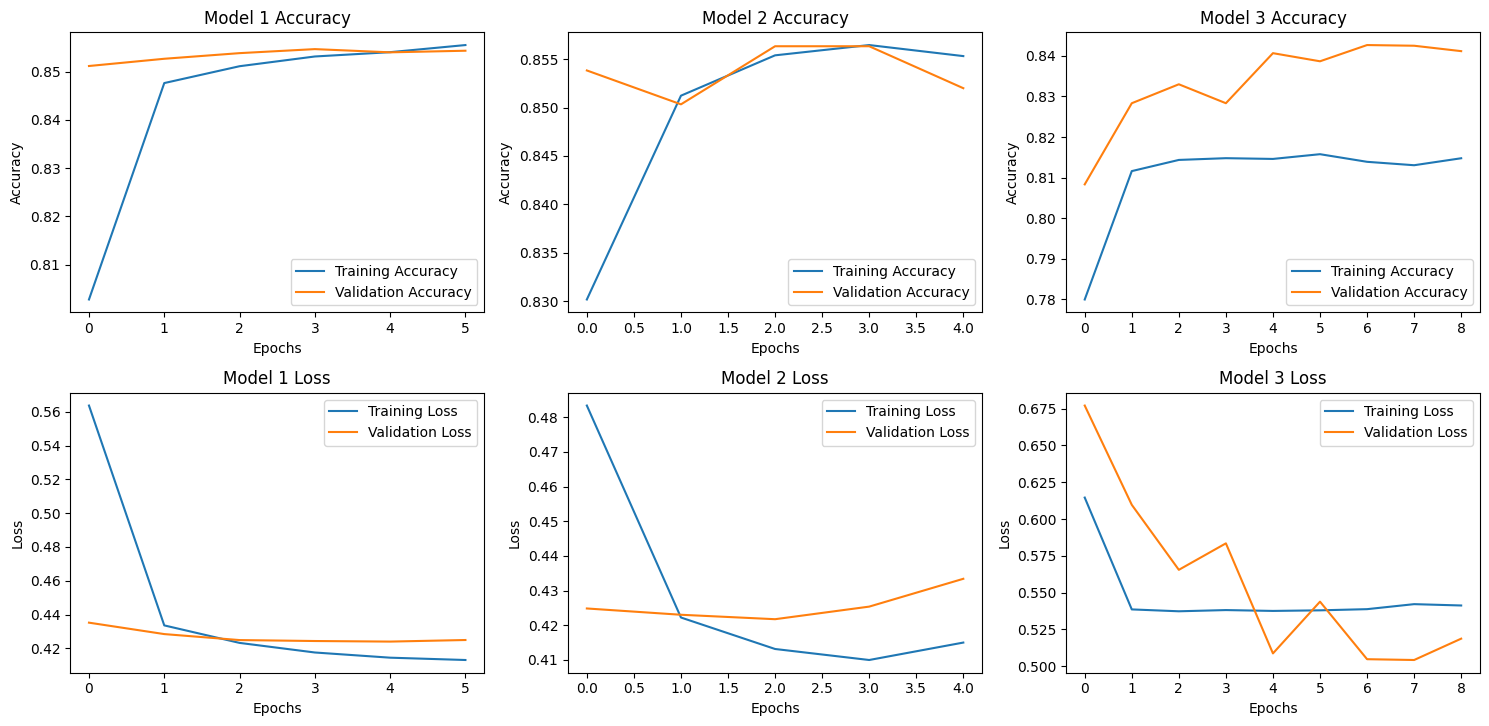

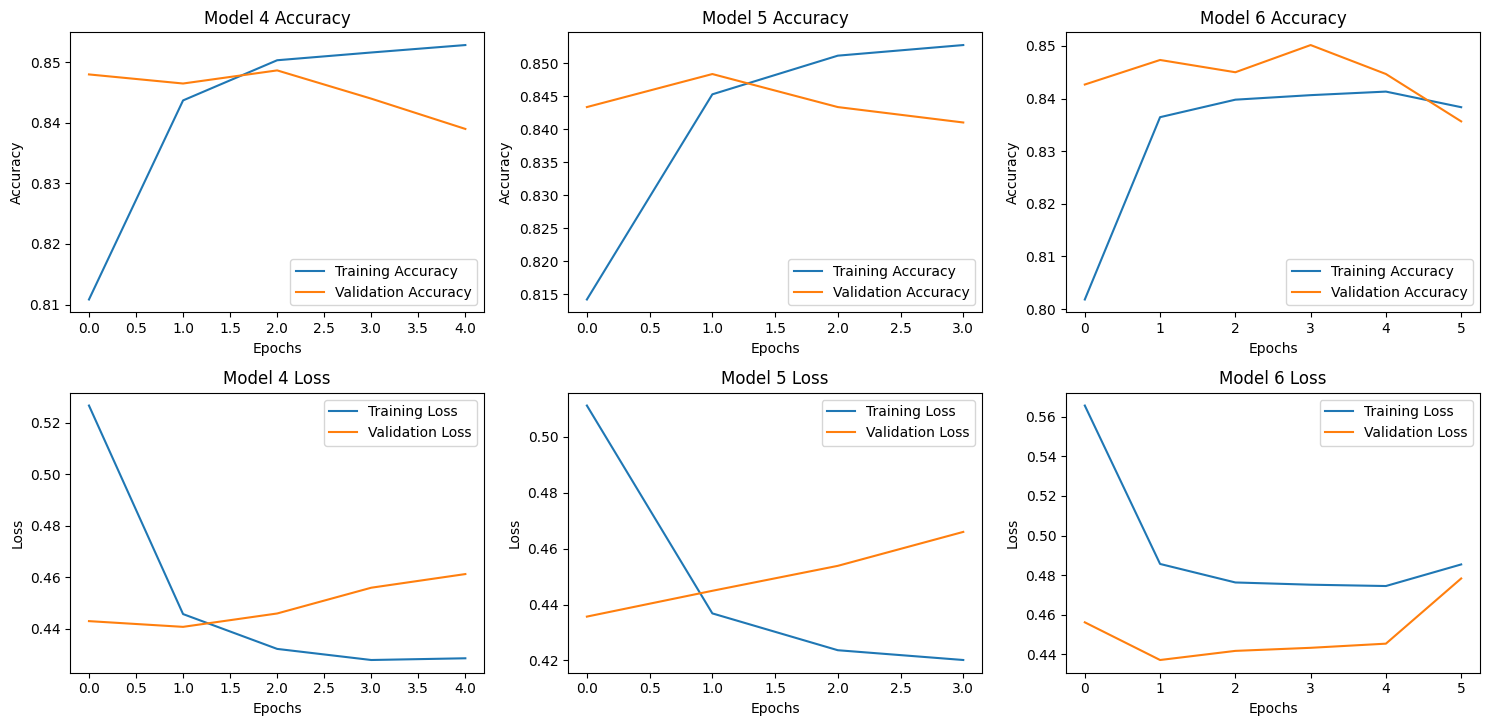

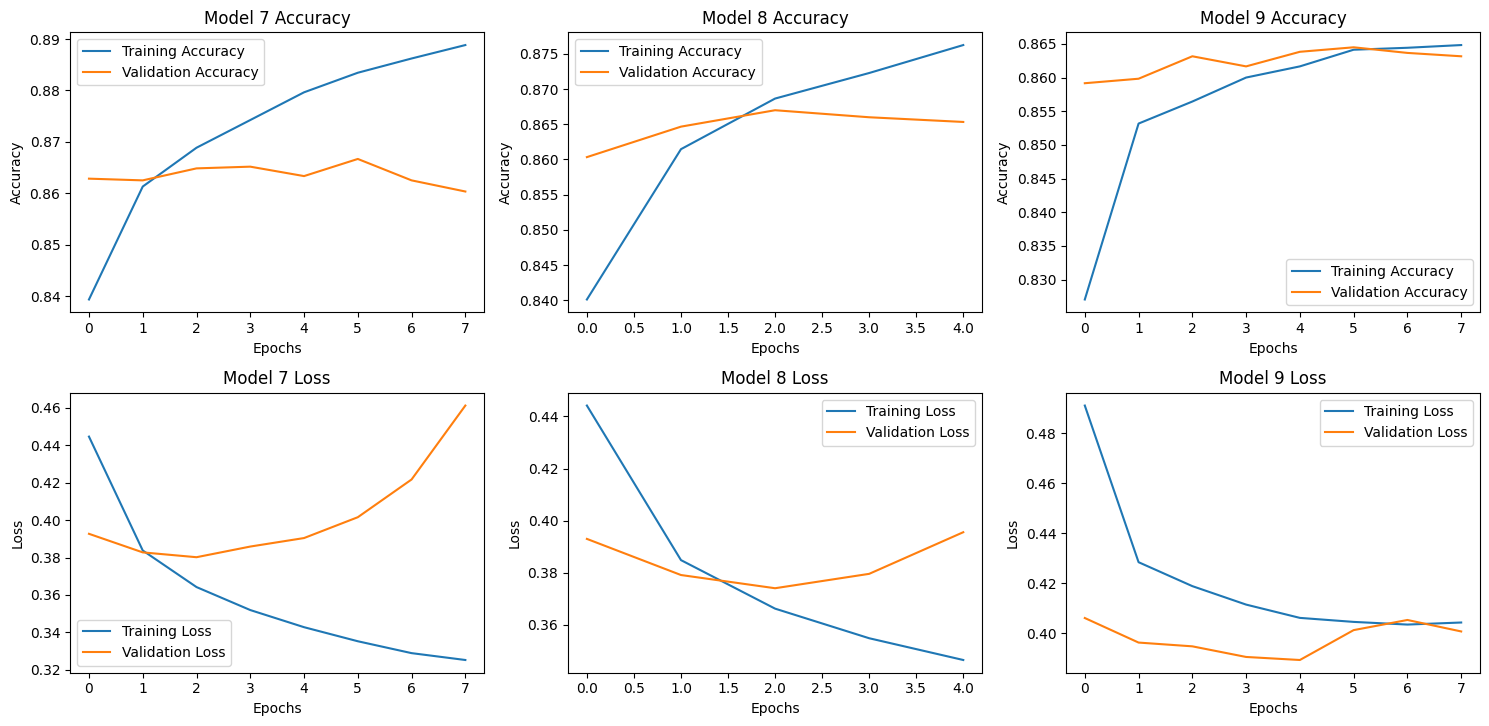

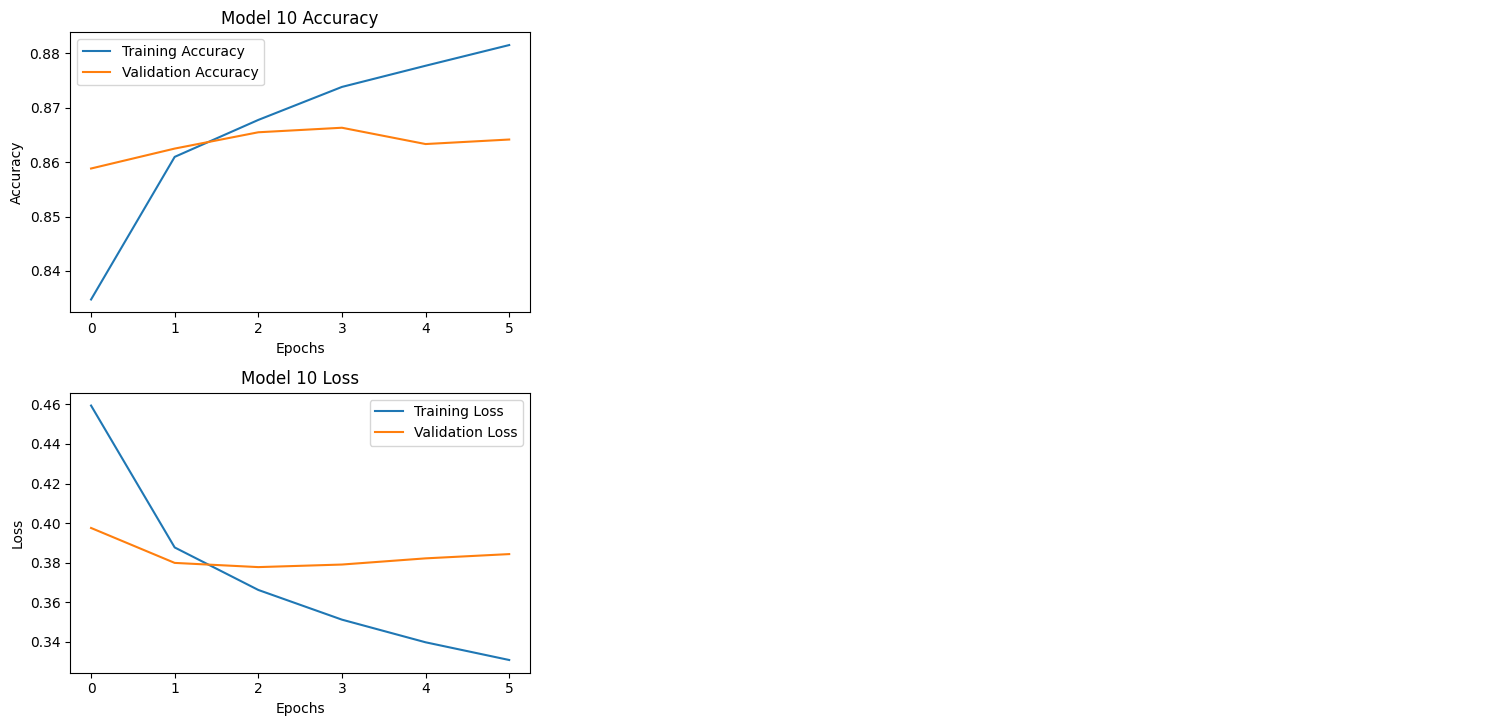

In [109]:
plot_training_history([history_one,history_two,history_three],0)
plot_training_history([history_four,history_five,history_six],3)
plot_training_history([history_seven,history_eight,history_nine],6)
plot_training_history([history_ten],9)

In [110]:
def plot_confusion_matrices(y_preds, y_true):
    num_sets = len(y_preds)
    cols = min(3, num_sets)  # Changed from 4 to 3
    rows = (num_sets + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)

    for i, (y_pred, ax) in enumerate(zip(y_preds, axs.flat)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(f"Model {i+1}")

    # Remove any empty subplots in the bottom row
    for i in range(num_sets, rows * cols):
        axs.flat[i].axis("off")

    plt.tight_layout()
    plt.show()

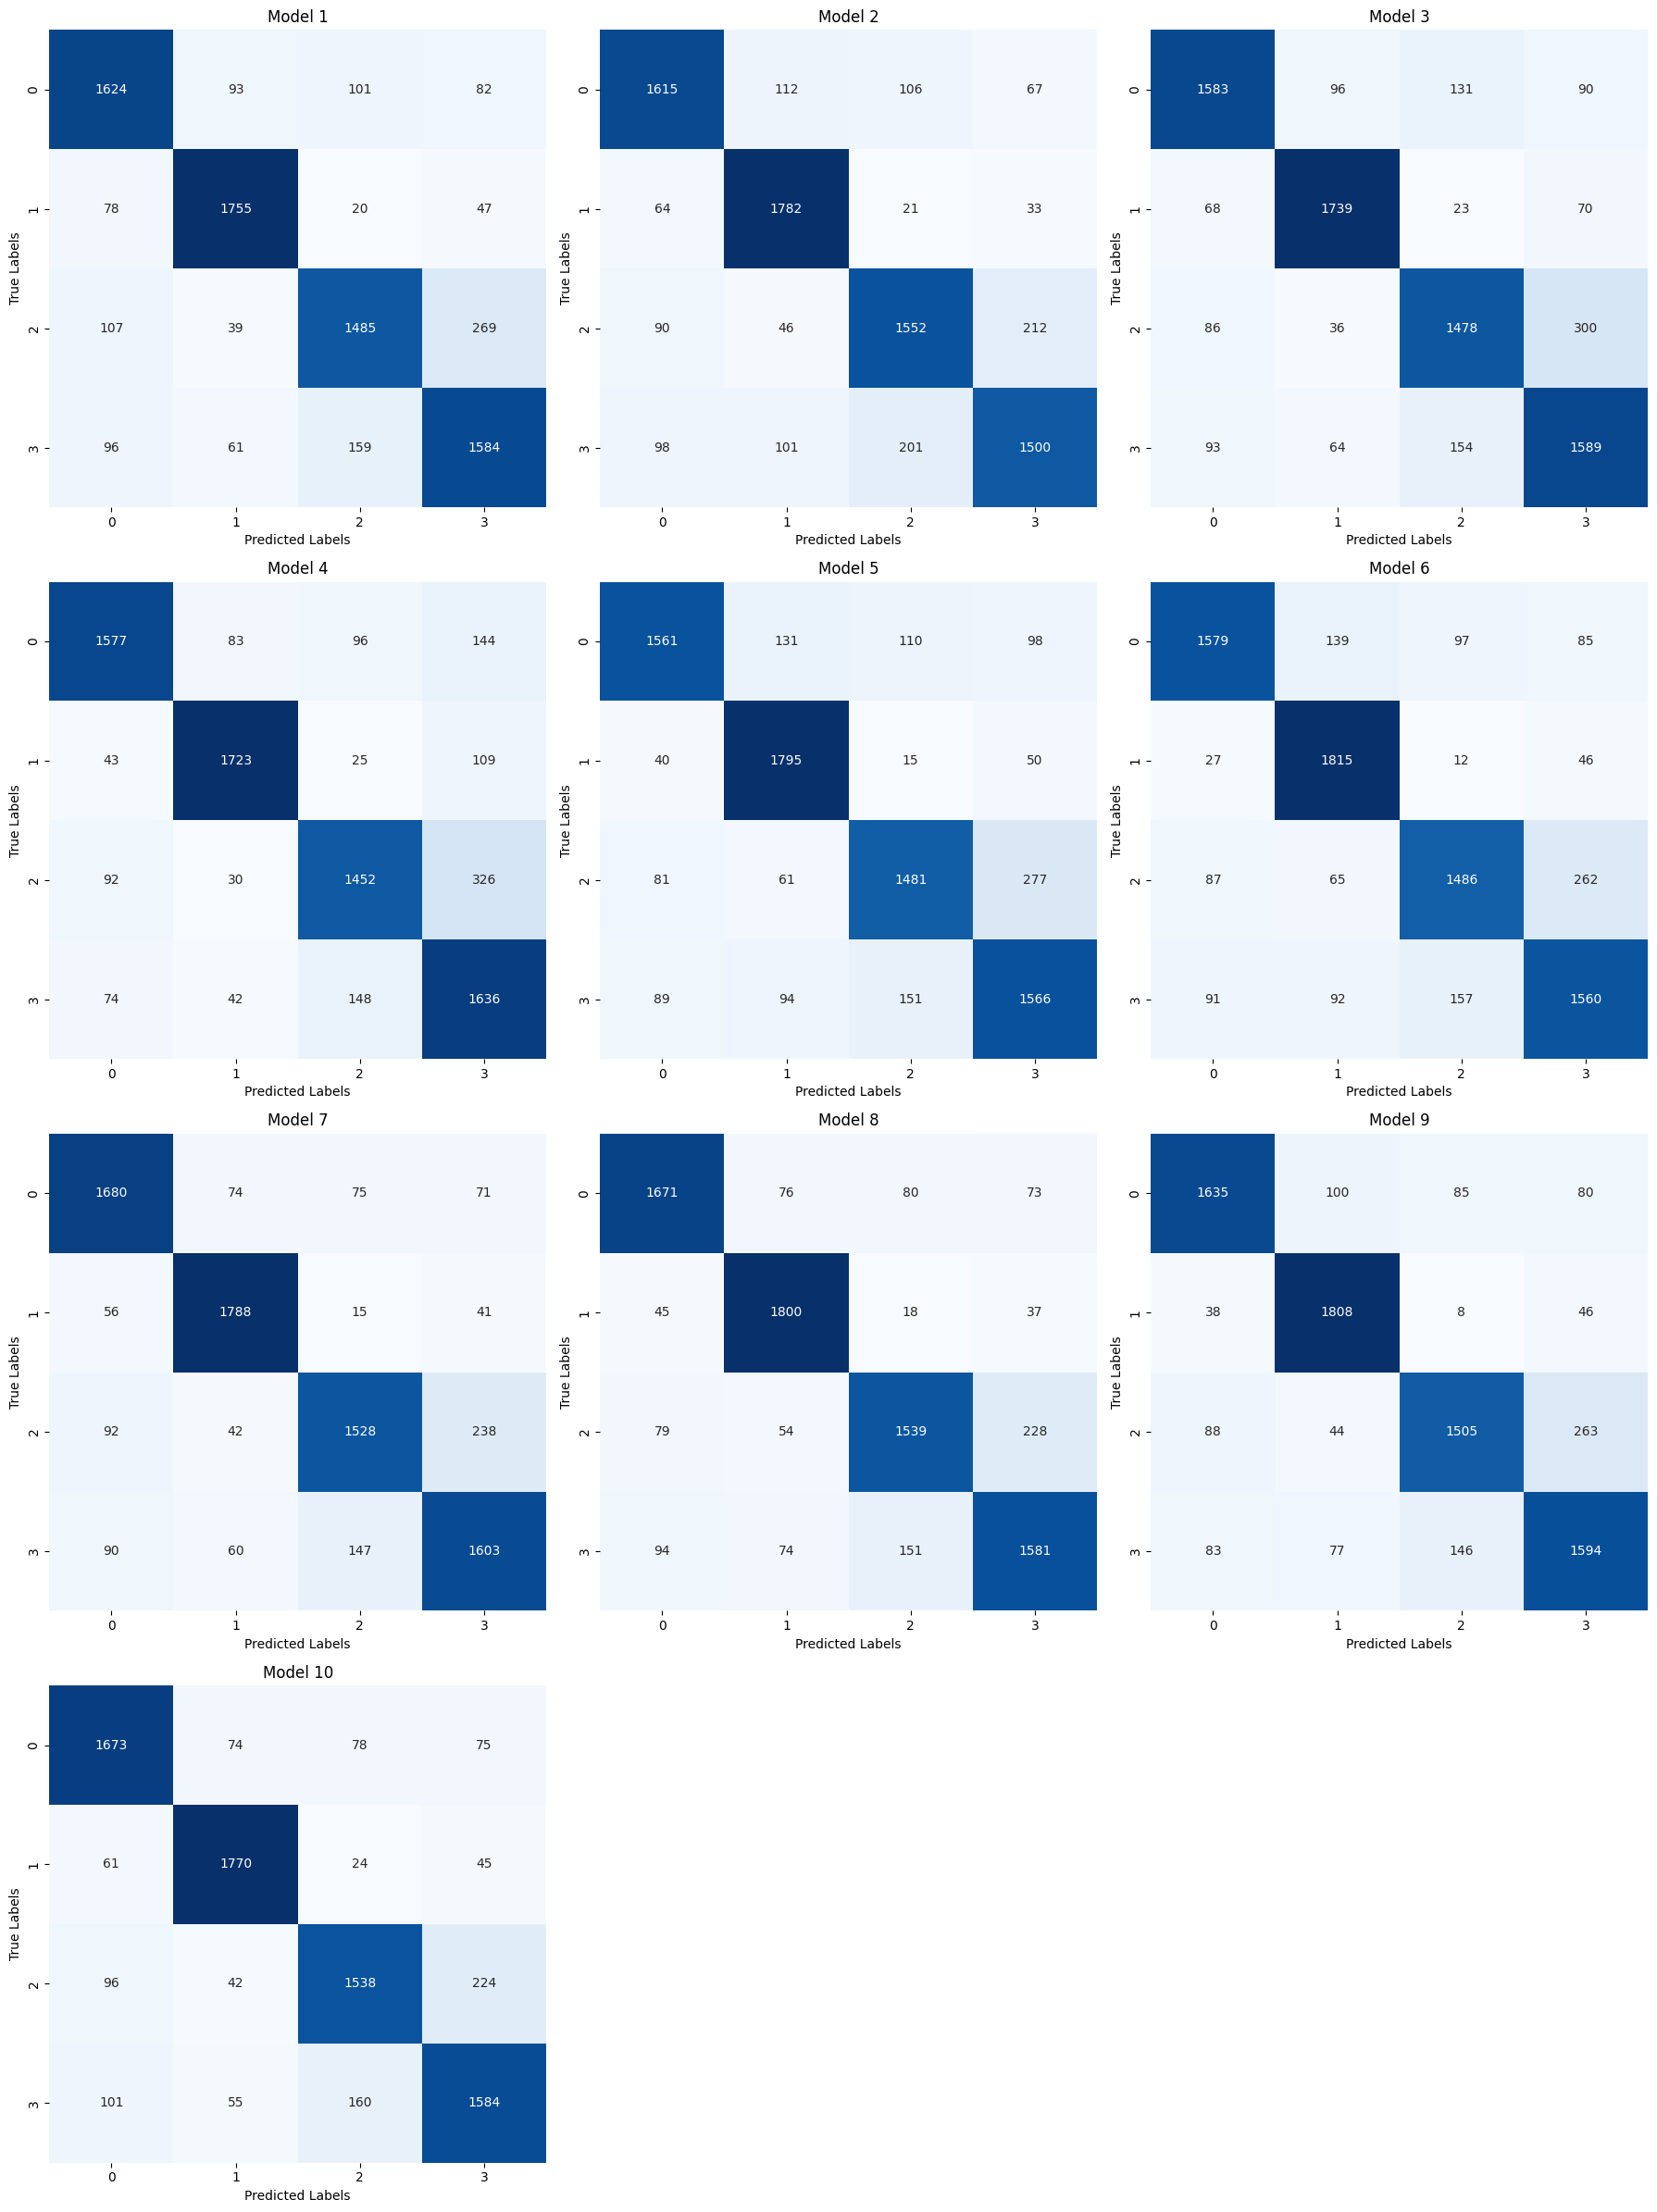

In [111]:
plot_confusion_matrices(
    [pred_one,
    pred_two,
    pred_three,
    pred_four,
    pred_five,
    pred_six,
    pred_seven,
    pred_eight,
    pred_nine,
    pred_ten,
    ]
    ,y_test
)